# Analiza danych z DIY Stack Exchange

## Wstęp
Przed przystąpieniem do analizy danych zadaliśmy sobie następujące pytania:
- czy pandemia i tym samym przymus pozostawania w domu miał wpływ na zainteresowanie tematyką diy i lifehacków?
- jak zmieniał się poziom zaangażowania użytkowników w czasie?

## Analiza
### Importowanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.notebook_repr_html", False)  # disable "rich" output
plt.style.use("seaborn")  # plot style

plt.rcParams.update({
    "font.size":         11,
    "figure.autolayout": True,
    "figure.dpi":        300,
    "figure.figsize":    (6, 3.5),  # default is [8.0, 5.5],
})

### Wczytanie danych

In [2]:
posts = pd.read_xml("diy/Posts.xml", parser = 'etree')
tags = pd.read_xml("diy/Tags.xml", parser = 'etree')

### 1. Liczba postów opublikowanych w danym kwartale

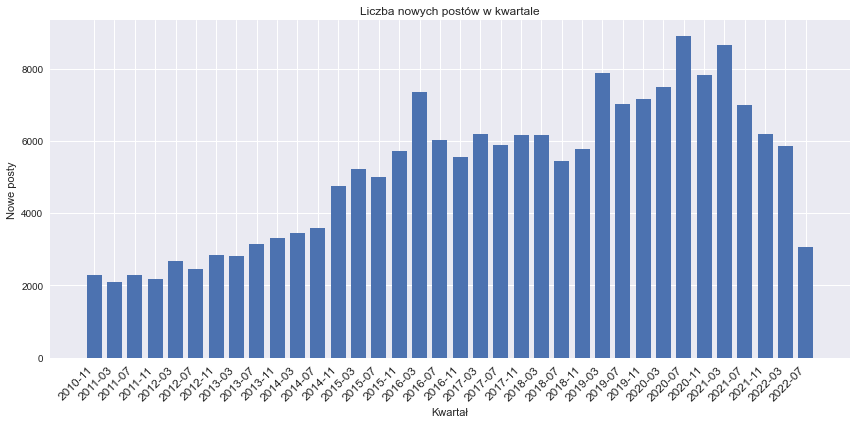

In [3]:
posts['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), 1) for date in posts.CreationDate]

grouped = posts.groupby(by=posts.CreationDateMonth)['Id'].count().reset_index()

grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
grouped.sort_values(by = "Month", ascending=True, inplace=True)

interval = grouped.resample('4m', on='Month').Count.sum()[1:].reset_index()

fig = plt.subplots(figsize=(12, 6))

plt.bar(interval['Month'], interval['Count'], width = 90)
plt.xticks(interval['Month'], interval['Count'], rotation=45, fontsize='12', horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Liczba nowych postów w kwartale')
plt.xlabel('Kwartał')
plt.ylabel('Nowe posty')
plt.show()

Jak można zauważyć, od marca 2020 do lipca 2021 roku jest zauważalny wzrost liczby publikowanych postów, może to wynikać z tego, że ludzie zmuszeni do pozostawania w domach szukali sposobów urozmaicania sobie czasu. Przyjrzyjmy się co mogło mieć wpływ na ten skok zainteresowania.

### Analiza tagów

In [4]:
popularTags = tags[ tags.Count > 500 ].sort_values(by=["Count"], ascending = False)
popularTags = popularTags['TagName'][:10].to_list()

       Id           TagName  Count  ExcerptPostId  WikiPostId
47     61        electrical  14151         3354.0      3353.0
273   414            wiring   6560        12475.0     12474.0
44     55          plumbing   5805         1624.0      1623.0
116   170              hvac   2671         5928.0      5927.0
28     37          lighting   2545         7888.0      7887.0
4       5          bathroom   2208         8687.0      8686.0
80    112             water   1872         8695.0      8694.0
598  1138  electrical-panel   1858       102699.0    102698.0
5       6           drywall   1841         4455.0      4454.0
275   418            switch   1787        30943.0     30942.0


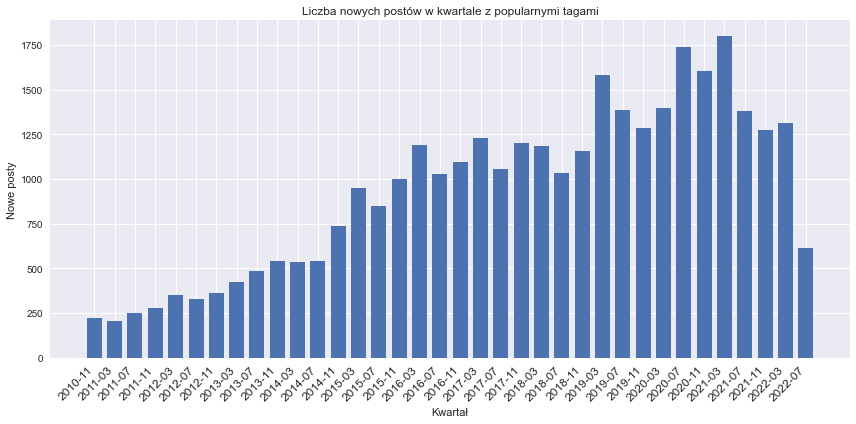

In [6]:
topTags = tags.nlargest(10, 'Count').sort_values('Count', ascending = False)

def checkIfInTopTags(row):
    if pd.isna(row["Tags"]):
        return False
    return any(topTag in row["Tags"] for topTag in topTags["TagName"])

posts["IsInTopTags"]= posts.apply (lambda row: checkIfInTopTags(row), axis=1)

print(topTags)

grouped = posts[posts["IsInTopTags"]==True].groupby(by=posts.CreationDateMonth)['Id'].count().reset_index()

grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
grouped.sort_values(by = "Month", ascending=True, inplace=True)

interval = grouped.resample('4m', on='Month').Count.sum()[1:].reset_index()
fig = plt.subplots(figsize=(12, 6))

plt.bar(interval['Month'], interval['Count'], width = 90)
plt.xticks(interval['Month'], interval['Count'], rotation=45, fontsize='12', horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Liczba nowych postów w kwartale z popularnymi tagami')
plt.xlabel('Kwartał')
plt.ylabel('Nowe posty')
plt.show()

## Cos